<a href="https://colab.research.google.com/github/mongbro/colab/blob/main/11_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### keras CNN으로 폐렴 X-Ray 구분하기

1. 패키지 수입 및 파라미터 지정

In [1]:
# 패키지 수입
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import Model
from keras.layers import Conv2D, SeparableConv2D
from keras.layers import Input, Flatten
from keras.layers import BatchNormalization, MaxPool2D
from keras.layers import Dense, Dropout
from keras.preprocessing.image import load_img

In [2]:
# 파라미터 지정
MY_EPOCH = 200
MY_BATCH = 100
MY_RES = 180
MY_SHAPE = (MY_RES, MY_RES, 3)

# 모드 설정
DATA_MODE = 0
TRAIN_MODE = 1
MY_PATH = '/content/drive/MyDrive/Colab Notebooks/data/chest'


2. 데이터 처리

In [3]:
# 변수 정의
  #######################################################################
  ## T_tot : train total 학습용 데이터 이미지 갯수                     ##
  ## V_tot : validation total 평가용 데이터 이미지 갯수                ##
  ## N_tot : 정상 이미지 갯수                                          ##
  ## P_tot : 폐렴 이미지 갯수                                          ##
  ## N_path : normal image path 정상 이미지 경로                       ##
  ## P_path : pneumonia image path 폐렴 이미지 경로                    ##
  #######################################################################

T_tot = V_tot = N_tot = P_tot = 0
N_path = P_path = []
X_train = np.zeros((0))
Y_train = np.zeros((0))
X_test = np.zeros((0))
Y_test = np.zeros((0))

In [4]:
# 학습용 입력 이미지 경로 처리
def train_path():
    global T_tot, N_tot, P_tot, N_path, P_path
    
    # 정상 이미지 처리
    dir = os.path.join(MY_PATH, 'train/NORMAL')
    print(dir)
    
    # 정상 이미지 파일 경로
    N_path = []
    for f in os.listdir(dir):
        N_path.append(os.path.join(dir, f))
    print('학습용 정상 이미지 수 :', len(N_path))
    N_tot = len(N_path)

    # 폐렴 이미지 처리
    dir = os.path.join(MY_PATH, 'train/PNEUMONIA')
    print(dir)

    # 이미지 파일 경로
    P_path = []
    for f in os.listdir(dir):
        P_path.append(os.path.join(dir, f))
    print('학습용 폐렴 이미지 수 :', len(P_path)) 
    P_tot = len(P_path)

    # 총 학습용 이미지 수
    T_tot = N_tot + P_tot
    print('학습용 이미지 수 :', T_tot)

In [5]:
# 학습용 이미지 데이터 처리 (화상도 통일)
# 정상 라벨은 0, 폐렴 라벨은 1
def train_resize():
    global T_tot, N_tot, P_tot, N_path, P_path
    global X_train, Y_train
    print('정상 이미지 처리 시작')
    begin = time()

    X_train = np.zeros((T_tot, MY_RES, MY_RES, 3))
    Y_train = np.zeros((T_tot, ))
    
    for i, path in enumerate(N_path):
        #tmp = load_img(path)
        #print(np.array(tmp).shape)
        #plt.imshow(tmp)
        #plt.show()
        img = load_img(path, 
                       target_size = (MY_RES, MY_RES))
        #print(np.array(img).shape)
        #plt.imshow(img)
        #plt.show()
        X_train[i] = img
        Y_train[i] = 0
        #print(X_train[i].shape)
        
    end = time()
    print("정상 이미지 처리 소요 시간 : {:.2f}초".format(end - begin))


########################### 정상 이미지 종료 ###########################


    print('폐렴 이미지 처리 시작')
    begin = time()

    for i, path in enumerate(P_path):
        img = load_img(path,
                       target_size = (MY_RES, MY_RES))
        X_train[i + N_tot] = img
        Y_train[i + N_tot] = 1
    
    # [0, 255] 8비트 컬러 정보를 [0, 1]로 스케일
    #print(X_train[0])
    X_train = X_train / 255.0

    end = time()
    print("폐렴 이미지 처리 소요 시간 : {:.2f}초".format(end - begin))

In [6]:
# 평가용 데이터 경로 처리
def test_path():
    global V_tot, N_tot, P_tot, N_path, P_path

    # 정상 이미지 처리
    dir = os.path.join(MY_PATH, 'test/NORMAL')
    print(dir)
    
    # 정상 이미지 파일 경로
    N_path = []
    for f in os.listdir(dir):
        N_path.append(os.path.join(dir, f))
    print('평가용 정상 이미지 수 :', len(N_path))
    N_tot = len(N_path)

    # 폐렴 이미지 처리
    dir = os.path.join(MY_PATH, 'test/PNEUMONIA')
    print(dir)

    # 이미지 파일 경로
    P_path = []
    for f in os.listdir(dir):
        P_path.append(os.path.join(dir, f))
    print('평가용 폐렴 이미지 수 :', len(P_path)) 
    P_tot = len(P_path)

    # 총 평가용 이미지 수
    V_tot = N_tot + P_tot
    print('평가용 이미지 수 :', V_tot)

In [7]:
# 평가용 이미지 데이터 처리 (화상도 통일)
# 정상 라벨은 0, 폐렴 라벨은 1
def test_resize():
    global V_tot, N_tot, P_tot, N_path, P_path
    global X_test, Y_test
    print('정상 이미지 처리 시작')
    begin = time()

    X_test = np.zeros((V_tot, MY_RES, MY_RES, 3))
    Y_test = np.zeros((V_tot, ))
    
    for i, path in enumerate(N_path):
        #tmp = load_img(path)
        #print(np.array(tmp).shape)
        #plt.imshow(tmp)
        #plt.show()
        img = load_img(path, 
                       target_size = (MY_RES, MY_RES))
        #print(np.array(img).shape)
        #plt.imshow(img)
        #plt.show()
        X_test[i] = img
        Y_test[i] = 0
        #print(X_train[i].shape)
        
    end = time()
    print("정상 이미지 처리 소요 시간 : {:.2f}초".format(end - begin))


########################### 정상 이미지 종료 ###########################


    print('폐렴 이미지 처리 시작')
    begin = time()

    for i, path in enumerate(P_path):
        img = load_img(path,
                       target_size = (MY_RES, MY_RES))
        X_test[i + N_tot] = img
        Y_test[i + N_tot] = 1
    
    # [0, 255] 8비트 컬러 정보를 [0, 1]로 스케일
    #print(X_test[0])
    X_test = X_test / 255.0

    end = time()
    print("폐렴 이미지 처리 소요 시간 : {:.2f}초".format(end - begin))

In [8]:
# 사분할 데이터 저장
def save_data():
    global X_train, Y_train, X_test, Y_test
    with open('chest_arrays.npy', 'wb') as f:
        np.save(f, X_train)
        np.save(f, Y_train)
        np.save(f, X_test)
        np.save(f, Y_test)

    print('데이터 파일 쓰기 완성')
    print('READ_WAV를 0으로 바꾸고 진행하세요')

In [9]:
# 사분할 데이터 읽기
def read_data():
    global X_train, Y_train, X_test, Y_test
    with open('chest_arrays.npy', 'rb') as f:
        X_train = np.load(f)
        Y_train = np.load(f)
        X_test = np.load(f)
        Y_test = np.load(f)

    print('데이터 파일 읽기 완성') 

In [10]:
# 데이터 처리 컨트롤 타워
if DATA_MODE:
    train_path()
    train_resize()
    test_path()
    test_resize()
    save_data()
else:
    read_data()

데이터 파일 읽기 완성


In [11]:

# 데이터 모양 확인
print('학습용 입력 데이터 모양 :', X_train.shape)
print('학습용 출력 데이터 모양 :', Y_train.shape)

print('평가용 입력 데이터 모양 :', X_test.shape)
print('평가용 출력 데이터 모양 :', Y_test.shape)

학습용 입력 데이터 모양 : (1000, 180, 180, 3)
학습용 출력 데이터 모양 : (1000,)
평가용 입력 데이터 모양 : (200, 180, 180, 3)
평가용 출력 데이터 모양 : (200,)


3. 인공 신경망 구현

In [12]:
# 합성곱 블럭 함수
def conv_block(filters, inputs):
    x = SeparableConv2D(filters = filters,
                        kernel_size = 3,
                        activation = 'relu',
                        padding = 'same')(inputs)

    x = SeparableConv2D(filters = filters,
                        kernel_size = 3,
                        activation = 'relu',
                        padding = 'same')(x)

    x = BatchNormalization()(x)

    output = MaxPool2D(pool_size = 2)(x)

    return output

In [13]:
# Dense 블럭 함수
def dense_block(units, drop, input):
    x = Dense(units = units,
              activation = 'relu')(input)

    x = BatchNormalization()(x)

    output = Dropout(drop)(x)
    
    return output

In [14]:
# 전체 CNN 구현

# 입력층
my_input = Input(shape = (MY_SHAPE))

# 2번 블럭
x = Conv2D(filters = 16,
           kernel_size = 3,
           activation = 'relu',
           padding = 'same')(my_input)

x = Conv2D(filters = 16,
           kernel_size = 3,
           activation = 'relu',
           padding = 'same')(x)

x = MaxPool2D(pool_size = 2)(x)

# 3번 블럭
x = conv_block(32, x)

# 4번 블럭
x = conv_block(64, x)

# 5번 블럭
x = conv_block(128, x)

# 6번 블럭
x = conv_block(256, x)
x = Dropout(0.2)(x)

# 7번 블럭
x = Flatten()(x)

# 8번 블럭
x = dense_block(512, 0.7, x)
x = dense_block(128, 0.5, x)
x = dense_block(64, 0.3, x)

# 9번 블럭
my_output = Dense(units = 1,
          activation = 'sigmoid')(x)




# 모델 만들기
model = Model(inputs = my_input,
              outputs = my_output)
print('CNN 요약')
model.summary()

CNN 요약
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 90, 90, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 90, 90, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 32)       

4. 인공 신경망 학습

In [15]:
# CNN 학습
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

# 학습 시작
print('학습 시작')
begin = time()

model.fit(x = X_train, 
          y = Y_train,
          epochs = MY_EPOCH,
          batch_size = MY_BATCH,
          verbose = 1)

end = time()

print('학습 시간 : {:.2f}초'.format(end - begin))

학습 시작
Epoch 1/200
10/10 [==============================] - 8s 313ms/step - loss: 0.7031 - acc: 0.6435
Epoch 2/200
10/10 [==============================] - 3s 316ms/step - loss: 0.3375 - acc: 0.8665
Epoch 3/200
10/10 [==============================] - 3s 295ms/step - loss: 0.2336 - acc: 0.8999
Epoch 4/200
10/10 [==============================] - 3s 312ms/step - loss: 0.2316 - acc: 0.9127
Epoch 5/200
10/10 [==============================] - 3s 306ms/step - loss: 0.1630 - acc: 0.9438
Epoch 6/200
10/10 [==============================] - 3s 317ms/step - loss: 0.1374 - acc: 0.9496
Epoch 7/200
10/10 [==============================] - 3s 310ms/step - loss: 0.1096 - acc: 0.9569
Epoch 8/200
10/10 [==============================] - 3s 311ms/step - loss: 0.1044 - acc: 0.9627
Epoch 9/200
10/10 [==============================] - 3s 313ms/step - loss: 0.0653 - acc: 0.9818
Epoch 10/200
10/10 [==============================] - 3s 318ms/step - loss: 0.0810 - acc: 0.9678
Epoch 11/200
10/10 [=============

4. 인공 신경망 평가

In [17]:
# CNN 평가
score = model.evaluate(x = X_test, y = Y_test,
                       verbose = 1)

print('최종 손실값 : {:.2f}'.format(score[0]))
print('최종 정확도 : {:.2f}'.format(score[1]))

7/7 [==============================] - 0s 18ms/step - loss: 0.8728 - acc: 0.8700
최종 손실값 : 0.87
최종 정확도 : 0.87


5. 인공 신경망 예측

정답 : 1.0
예측 :  [[0.9999945]]


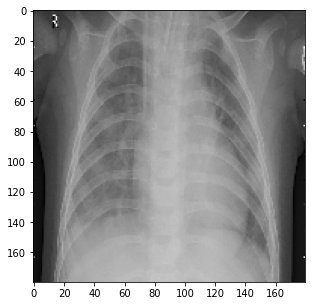

In [36]:
# CNN 예측
# 임의의 사진 하나 선택
plt.figure(figsize = (5, 5))
plt.imshow(X_test[120])
print('정답 :', Y_test[120])

sample = X_test[120].reshape(1, 180, 180, 3)
pred = model.predict(sample)

print("예측 : ", pred)